# Project 2 – Credit Card Fraud Detection

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
import torch.nn.functional as F

In [3]:
df = pd.read_excel("CreditCardDataset.xlsx")

## Performing EDA

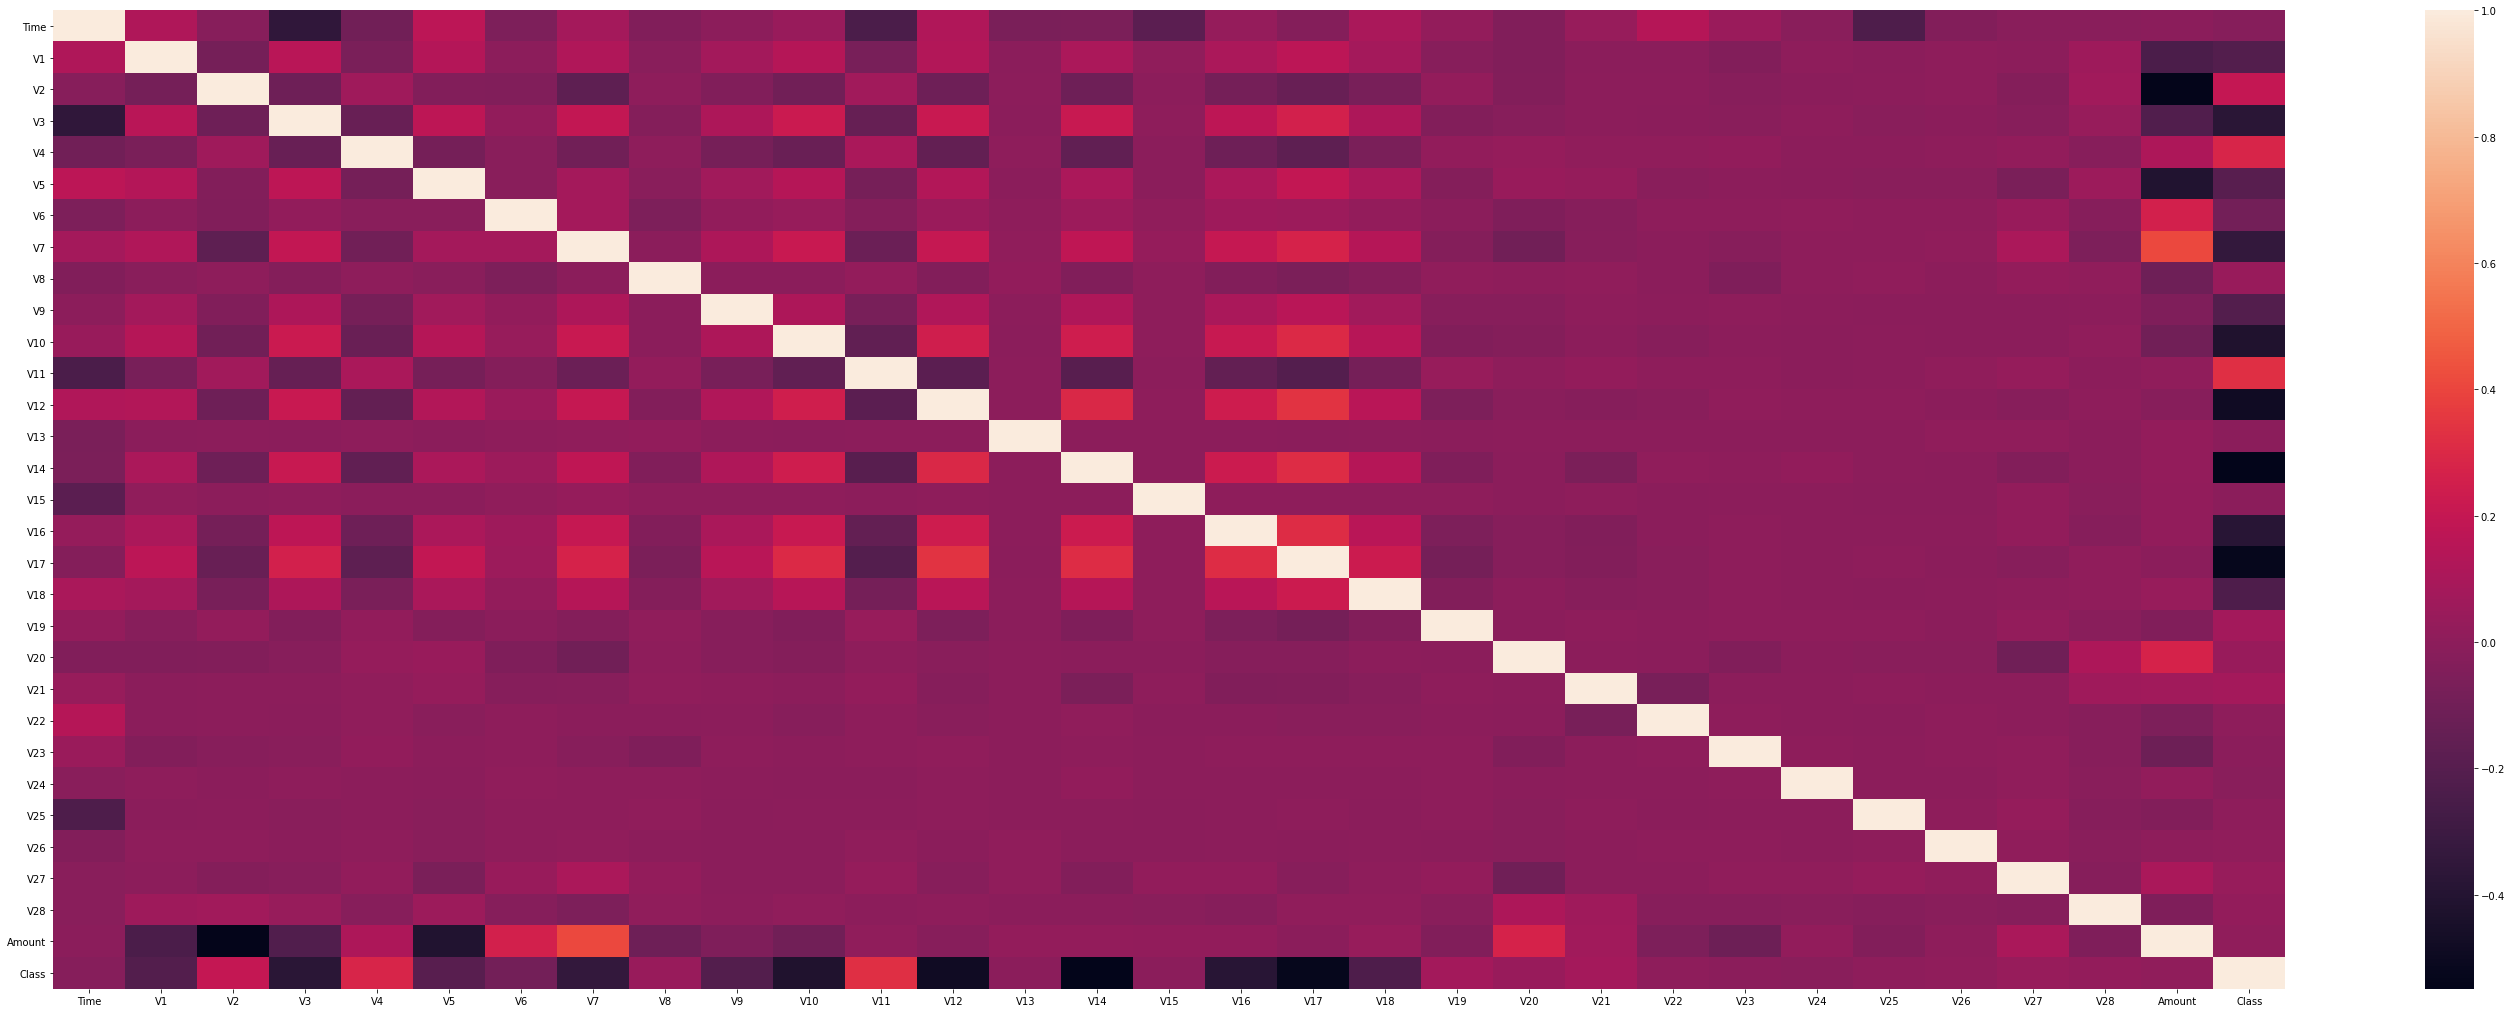

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
fig , ax = plt.subplots(figsize = (50,18))
sns.heatmap(df.corr() , annot = False , ax = ax)
plt.show()

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,...,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000,57355.000000
mean,94577.357074,-0.029092,0.030156,-0.055749,0.035521,-0.022664,-0.006869,-0.032448,0.006142,-0.017667,...,0.005569,-0.000265,0.003273,0.001159,0.005003,0.003133,0.000226,-0.000625,88.825575,0.008578
std,47505.713234,2.061391,1.711228,1.733364,1.484621,1.508300,1.361819,1.504317,1.334058,1.131679,...,0.813950,0.734597,0.625238,0.604653,0.519852,0.482496,0.433713,0.323980,279.496913,0.092221
min,2.000000,-36.802320,-63.344698,-48.325589,-5.519697,-113.743307,-19.996349,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-32.828995,-2.822384,-8.696627,-2.534330,-8.878665,-15.430084,0.000000,0.000000
25%,53943.500000,-0.927615,-0.588747,-0.922554,-0.839400,-0.692157,-0.774796,-0.558211,-0.207145,-0.651869,...,-0.226932,-0.541278,-0.161812,-0.354648,-0.312164,-0.322536,-0.070642,-0.052695,5.475000,0.000000
50%,84641.000000,0.015980,0.071801,0.168619,-0.005637,-0.055913,-0.276163,0.035797,0.024380,-0.053373,...,-0.028379,0.004681,-0.011439,0.041286,0.021494,-0.049135,0.000859,0.011169,21.990000,0.000000
75%,139140.000000,1.314129,0.815413,1.019384,0.764271,0.607021,0.387408,0.562758,0.333358,0.599522,...,0.190245,0.529286,0.147282,0.439244,0.352590,0.243882,0.091355,0.078500,76.900000,0.000000
max,172777.000000,2.454930,22.057729,3.940337,16.715537,28.762671,73.301626,120.589494,20.007208,10.348407,...,27.202839,10.503090,22.528412,4.584549,5.826159,3.517346,31.612198,15.866721,25691.160000,1.000000


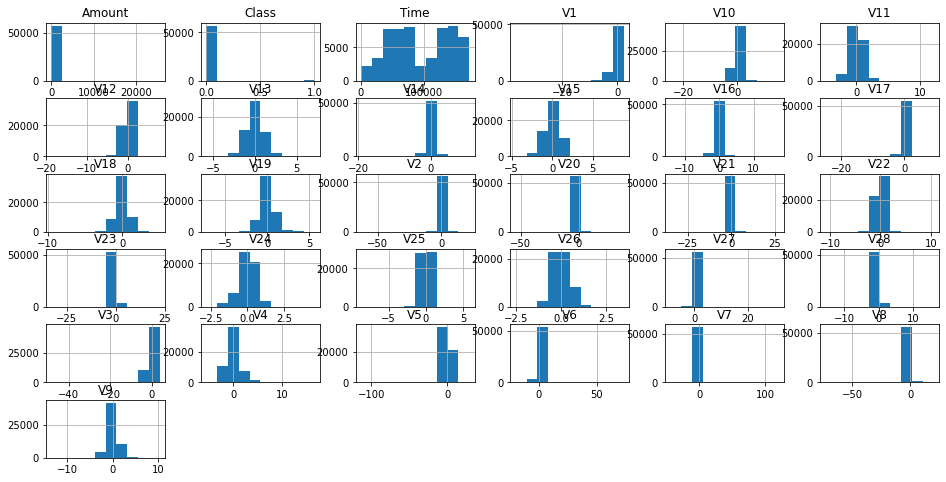

In [6]:
histograms = df.hist(figsize=(16,8))

## Data preprocessing

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#scaling time
scaled_time = scaler.fit_transform(df[['Time']])
list1 = [item for sublist in scaled_time.tolist() for item in sublist]
scaled_time = pd.Series(list1)

In [8]:
#scaling the amount column
scaled_amount = scaler.fit_transform(df[['Amount']])
list2 = [item for sublist in scaled_amount.tolist() for item in sublist]
scaled_amount = pd.Series(list2)

In [9]:
df = pd.concat([df, scaled_amount.rename('scaled_amount'), scaled_time.rename('scaled_time')], axis=1)

In [10]:
df.drop(['Amount', 'Time'], axis=1, inplace=True)

In [11]:
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.067392,-1.990838
1,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,0,-0.304677,-1.990838
2,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0,-0.171830,-1.990733
3,1.069374,0.287722,0.828613,2.712520,-0.178398,0.337544,-0.096717,0.115982,-0.221083,0.460230,...,0.074412,-0.071407,0.104744,0.548265,0.104094,0.021491,0.021293,0,-0.219416,-1.990649
4,-0.752417,0.345485,2.057323,-1.468643,-1.158394,-0.077850,-0.608581,0.003603,-0.436167,0.747731,...,1.353650,-0.256573,-0.065084,-0.039124,-0.087086,-0.180998,0.129394,0,-0.260598,-1.990628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57350,2.085387,-0.033624,-1.706889,-0.015100,0.644669,-0.245303,0.125758,-0.156508,0.277994,0.159894,...,0.862281,-0.063211,0.143339,0.361885,-0.124856,-0.025472,-0.066836,0,-0.309686,1.645577
57351,-6.713826,2.369104,-3.534768,-0.368259,-1.721030,-1.322808,-0.190876,0.891149,2.068476,2.769699,...,0.994246,-0.002140,-0.072979,-0.167159,-0.387271,-2.616341,0.474584,0,-0.247717,1.645767
57352,-2.076175,2.142238,-2.522704,-1.888063,1.982785,3.732950,-1.217430,-0.536644,0.272867,0.300342,...,-1.588269,0.588482,0.632444,-0.201064,0.199251,0.438657,0.172923,0,-0.285786,1.645935
57353,2.007418,-0.280235,-0.208113,0.335261,-0.715798,-0.751373,-0.458972,-0.140140,0.959971,-0.028284,...,-0.430347,0.416765,0.064819,-0.608337,0.268436,-0.028069,-0.041367,0,-0.303532,1.645977


In [12]:
df.isnull().sum()

V1               0
V2               0
V3               0
V4               0
V5               0
V6               0
V7               0
V8               0
V9               0
V10              0
V11              0
V12              0
V13              0
V14              0
V15              0
V16              0
V17              0
V18              0
V19              0
V20              0
V21              0
V22              0
V23              0
V24              0
V25              0
V26              0
V27              0
V28              0
Class            0
scaled_amount    0
scaled_time      0
dtype: int64

In [13]:
df.corr().Class.sort_values(ascending=False)

Class            1.000000
V11              0.323416
V4               0.282355
V2               0.195342
V21              0.080913
V19              0.077406
V20              0.042014
V8               0.039360
V27              0.036535
V28              0.021904
scaled_amount    0.011111
V26              0.009353
V25              0.006521
V22              0.001813
V23             -0.006484
V15             -0.009413
V13             -0.009564
V24             -0.016351
scaled_time     -0.027081
V6              -0.095003
V5              -0.192943
V9              -0.210705
V1              -0.214018
V18             -0.233606
V7              -0.342334
V3              -0.374441
V16             -0.385245
V10             -0.419692
V12             -0.487856
V17             -0.528504
V14             -0.549053
Name: Class, dtype: float64

Deleting the non correlated columns

In [14]:
del df['V7']
del df['V3']
del df['V16']
del df['V10']
del df['V17']
del df['V14']

Plotting outliners

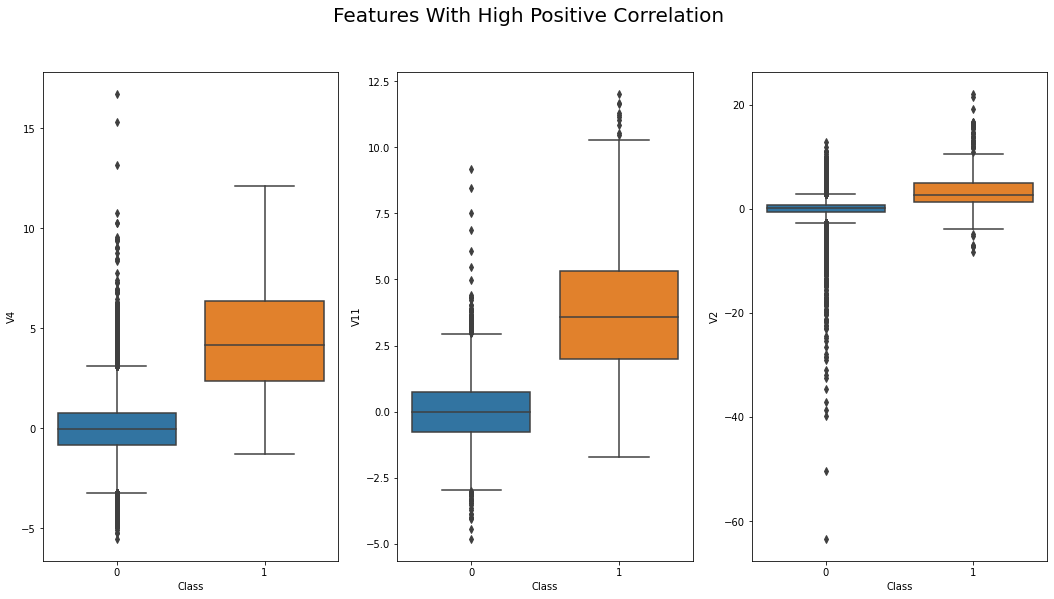

In [15]:
f, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,9))

f.suptitle('Features With High Positive Correlation', size=20)
sns.boxplot(x="Class", y="V4", data=df, ax=axes[0])
sns.boxplot(x="Class", y="V11", data=df, ax=axes[1])
sns.boxplot(x="Class", y="V2", data=df, ax=axes[2])

Removing outliners

In [16]:
#Only removing extreme outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

df2 = df[~((df < (Q1 - 2.5 * IQR)) |(df > (Q3 + 2.5 * IQR))).any(axis=1)]

In [17]:
len_after = len(df2)
len_before = len(df)
len_difference = len(df) - len(df2)
print('Reduced our data size from {} transactions by {} transactions to {} transactions.'.format(len_before, len_difference, len_after))

Reduced our data size from 57355 transactions by 14133 transactions to 43222 transactions.


In [18]:
df2

,V1,V2,V4,V5,V6,V8,V9,V11,V12,V13,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.158233,0.877737,0.403034,-0.407193,0.095921,-0.270533,0.817739,-0.822843,0.538196,1.345852,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.067392,-1.990838
1,-0.425966,0.960523,-0.168252,0.420987,-0.029728,0.260314,-0.568671,1.341262,0.359894,-0.358091,...,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,0,-0.304677,-1.990838
3,1.069374,0.287722,2.712520,-0.178398,0.337544,0.115982,-0.221083,-0.773657,0.323387,-0.011076,...,0.074412,-0.071407,0.104744,0.548265,0.104094,0.021491,0.021293,0,-0.219416,-1.990649
4,-0.752417,0.345485,-1.468643,-1.158394,-0.077850,0.003603,-0.436167,-0.793981,-0.770407,1.047627,...,1.353650,-0.256573,-0.065084,-0.039124,-0.087086,-0.180998,0.129394,0,-0.260598,-1.990628
5,1.166616,0.502120,2.261569,0.428804,0.089474,0.138082,-0.989162,0.744786,-0.531377,-2.105346,...,-0.061972,-0.103855,-0.370415,0.603200,0.108556,-0.040521,-0.011418,0,-0.309650,-1.990501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57347,2.033454,-0.106632,0.524309,-0.435380,-1.478768,-0.306666,0.659747,-0.529522,0.061354,-0.980949,...,-0.700522,0.404713,0.433135,-0.387225,0.173123,-0.076376,-0.057886,0,-0.314266,1.645198
57349,2.032031,0.231108,0.519949,0.282147,-1.064832,-0.295196,0.318850,0.092528,0.821848,0.889057,...,-0.752281,0.398598,1.017664,-0.309607,0.142321,-0.052772,-0.023982,0,-0.313193,1.645367
57350,2.085387,-0.033624,-0.015100,0.644669,-0.245303,-0.156508,0.277994,0.517462,1.050483,0.708285,...,0.862281,-0.063211,0.143339,0.361885,-0.124856,-0.025472,-0.066836,0,-0.309686,1.645577
57353,2.007418,-0.280235,0.335261,-0.715798,-0.751373,-0.140140,0.959971,-0.635200,0.869261,0.996596,...,-0.430347,0.416765,0.064819,-0.608337,0.268436,-0.028069,-0.041367,0,-0.303532,1.645977


## Implement a Neural Network using PyTorch Framework

In [19]:
X = df2.drop(["Class"], axis=1)
y = df2['Class']

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (34577, 24)
X_test shape is  (8645, 24)
y_train shape is  (34577,)
y_test shape is  (8645,)


In [22]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [23]:
from torch.utils.data import TensorDataset
train_loader = torch.utils.data.DataLoader(TensorDataset(torch.from_numpy(X_train),torch.from_numpy(y_train)), batch_size=len(X_train), shuffle=True)
test_loader  = torch.utils.data.DataLoader(TensorDataset(torch.from_numpy(X_test),torch.from_numpy(y_test)), batch_size=len(X_test), shuffle=True)

Creating function for defining model parameters

In [24]:
class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Model, self).__init__()

        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.sigmoid = nn.Sigmoid()
        self.layer2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.layer1(x)
        out = self.sigmoid(out)
        out = self.layer2(out)
        return out

Applying PyTorch model with adam optimizer and crossentropyloss function with 24 and 64 neurons in input and hidden layer resp.

In [25]:
input_dim = 24
hidden_dim = 64
num_of_classes = 2
batch_size = 60
model = Model(input_dim, hidden_dim, num_of_classes)
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 50

for epoch in range(epochs):
    train_correct = 0
    train_total = 0
    
    for i, (items, classes) in enumerate(train_loader):
        inputs = Variable(items.type(torch.FloatTensor))
        labels = Variable(classes.type(torch.LongTensor))

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, classes.type(torch.LongTensor))
        loss.backward()
        optimizer.step()

        model.train 
        train_total += classes.size(0)    
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == classes.data).sum()

        print ('Epoch %d/%d, Loss: %.4f' %(epoch+1, epochs, loss.data))
        
        
    train_loss.append(loss.data)

    # What was our train accuracy?
    train_accuracy.append((100 * train_correct / train_total))
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    test_items = torch.FloatTensor(X_test)
    test_classes = torch.LongTensor(y_test)

    outputs = model(Variable(test_items))
    loss1 = loss_func(outputs, Variable(test_classes))
    test_loss.append(loss1.data)
    _, predicted = torch.max(outputs.data, 1)
    total = test_classes.size(0)
    correct = (predicted == test_classes.data).sum()
    test_accuracy.append((100 * correct / total))

Epoch 1/50, Loss: 0.7692
Epoch 2/50, Loss: 0.4578
Epoch 3/50, Loss: 0.2595
Epoch 4/50, Loss: 0.1453
Epoch 5/50, Loss: 0.0829
Epoch 6/50, Loss: 0.0489
Epoch 7/50, Loss: 0.0301
Epoch 8/50, Loss: 0.0194
Epoch 9/50, Loss: 0.0129
Epoch 10/50, Loss: 0.0090
Epoch 11/50, Loss: 0.0064
Epoch 12/50, Loss: 0.0048
Epoch 13/50, Loss: 0.0036
Epoch 14/50, Loss: 0.0028
Epoch 15/50, Loss: 0.0022
Epoch 16/50, Loss: 0.0018
Epoch 17/50, Loss: 0.0015
Epoch 18/50, Loss: 0.0013
Epoch 19/50, Loss: 0.0011
Epoch 20/50, Loss: 0.0009
Epoch 21/50, Loss: 0.0008
Epoch 22/50, Loss: 0.0007
Epoch 23/50, Loss: 0.0006
Epoch 24/50, Loss: 0.0006
Epoch 25/50, Loss: 0.0005
Epoch 26/50, Loss: 0.0005
Epoch 27/50, Loss: 0.0005
Epoch 28/50, Loss: 0.0004
Epoch 29/50, Loss: 0.0004
Epoch 30/50, Loss: 0.0004
Epoch 31/50, Loss: 0.0004
Epoch 32/50, Loss: 0.0003
Epoch 33/50, Loss: 0.0003
Epoch 34/50, Loss: 0.0003
Epoch 35/50, Loss: 0.0003
Epoch 36/50, Loss: 0.0003
Epoch 37/50, Loss: 0.0003
Epoch 38/50, Loss: 0.0003
Epoch 39/50, Loss: 0.

## Plot training loss and validation loss

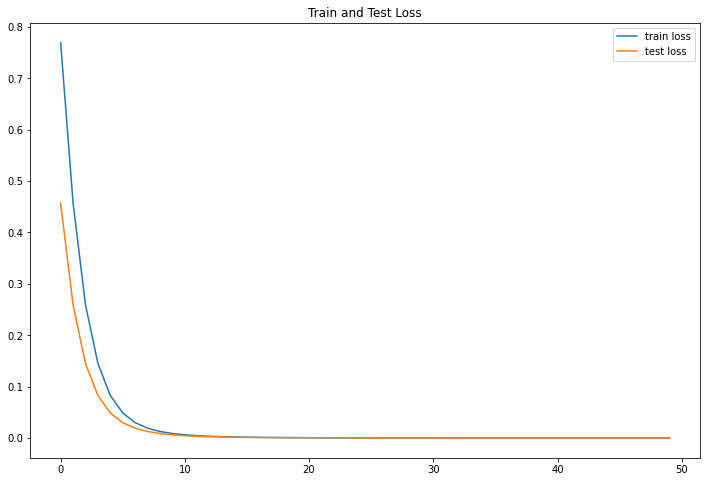

In [28]:
fig = plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.title("Train and Test Loss")
plt.legend()
plt.show()

1. We are getting low training and test loss that means model is perfectly fitting
2. Summation of the errors made by each epoch decreases with huge gradient
3. Model is not under or overfitting state

## Plot training accuracy and validation accuracy

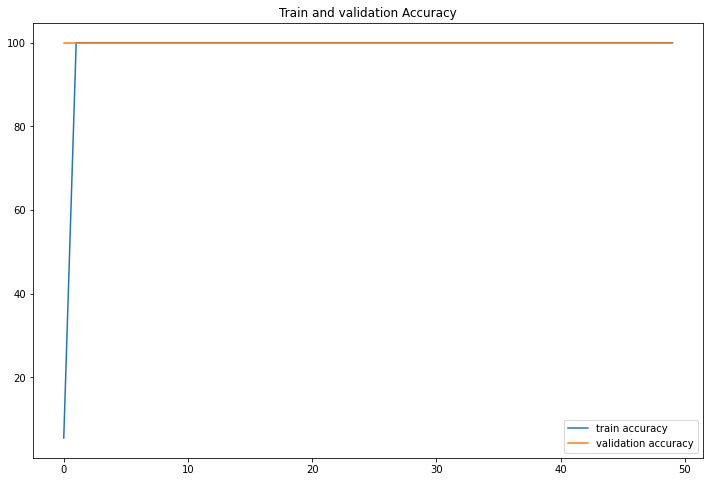

In [35]:
fig = plt.figure(figsize=(12, 8))
plt.plot(train_accuracy, label='train accuracy')
plt.plot(test_accuracy, label='validation accuracy')
plt.title("Train and validation Accuracy")
plt.legend()
plt.show()

1. High train and validation accuarcy validates our model
2. Normalization of the data and removing extra features columns also improved the accuracy levels
3. Due to the huge dataset fro training model seems to learn very accurately about the feature correlation